In [10]:
%matplotlib inline
import pandas as pd
import seaborn as sns

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [11]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

# Multiasset Value and Momentum 

Asness et al 2013 Value and Momentum Everywhere
Data available on AQR's webpage

In [22]:
data=pd.read_csv('AQR.csv',parse_dates=['DATE'], index_col=0)[['VAL','MOM']]

# Fama French (1993) Three Factor Model

* Market
* SMB (Small minus Big)
* HML (High minus Low)

Available on Kenneth French's Dartmouth webpage

In [23]:
data=data.join(pd.read_csv('FF.csv',parse_dates=['Date'],index_col=0).resample(rule='m',how='sum')/100.)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


AttributeError: 'FigureCanvasAgg' object has no attribute 'invalidate'

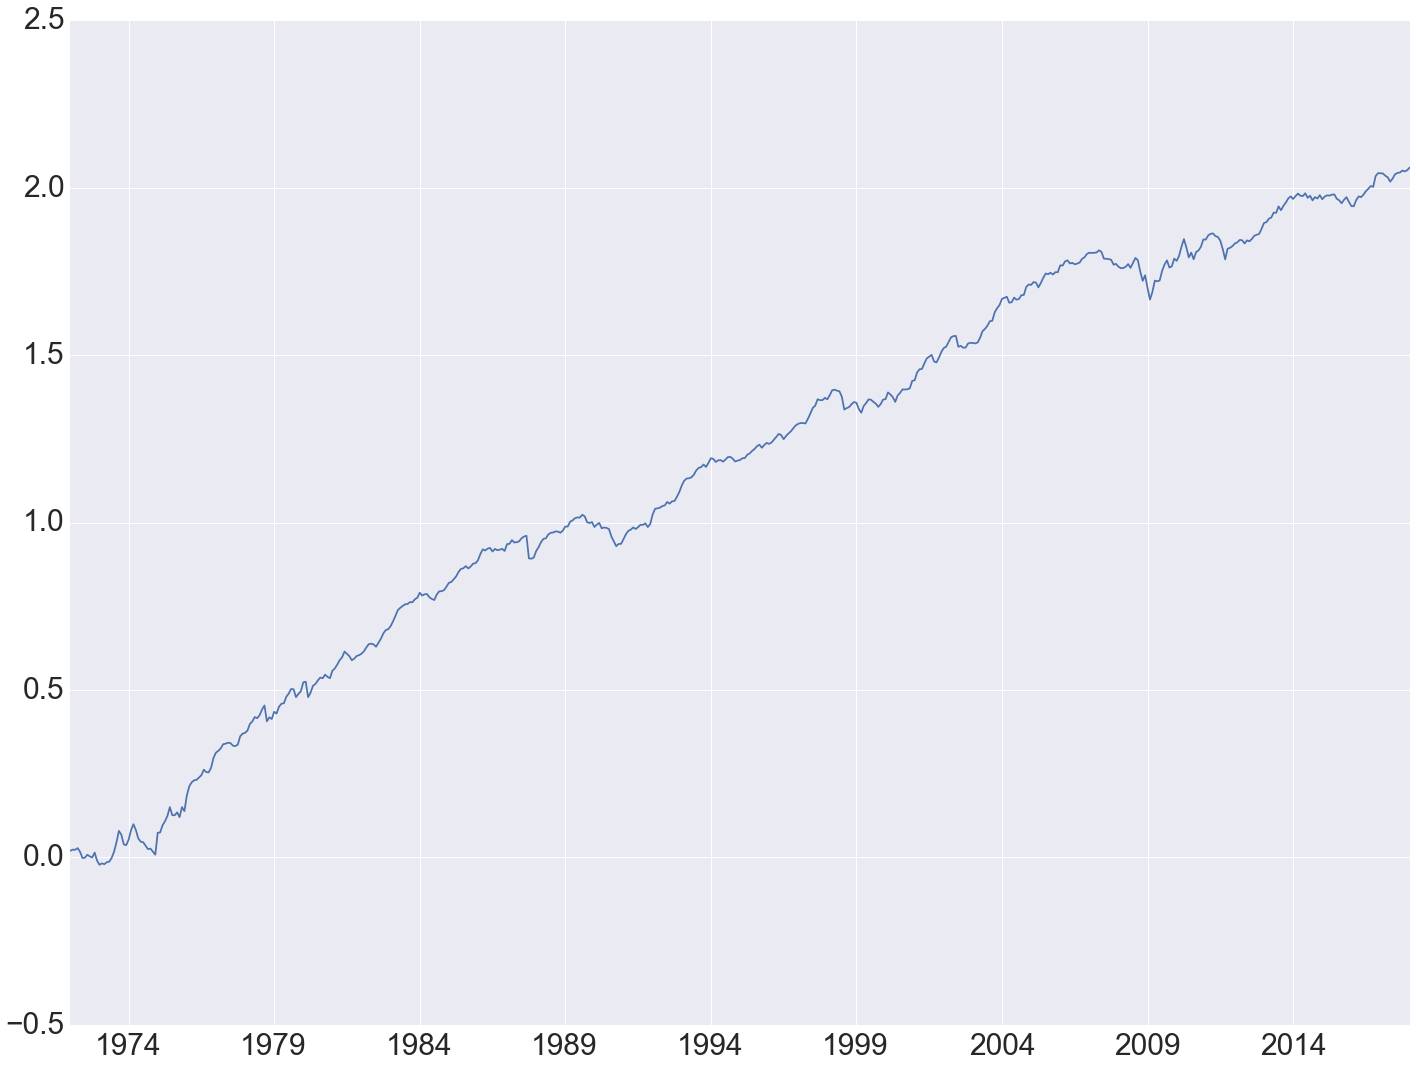

In [44]:
data[['VAL', 'MOM', 'Mkt-RF', 'SMB', 'HML']].mean(axis=1).cumsum().plot()